In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [28]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report

In [3]:
df = pd.read_csv('german.data', delim_whitespace=True, header=None)

In [4]:
df.columns = ['existing_check', 'duration', 'credit_hist', 'purpose', 'credit_amt', 
              'savings', 'employ_since', 'installment_rate', 'sex', 'other_debtors', 
              'residence_since', 'property', 'age', 'other_installment', 'housing', 
              'existing_credits', 'job', 'people_liable', 'telephone', 'foreign_worker', 'label']

In [5]:
df.head()

,existing_check,duration,credit_hist,purpose,credit_amt,savings,employ_since,installment_rate,sex,other_debtors,...,property,age,other_installment,housing,existing_credits,job,people_liable,telephone,foreign_worker,label
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


Exploratory Data Analysis

Checking the data type and values, we can see that the data contains 8 numerical variables and 13 categorical variables. Later we will convert this categorical variables into numerical using one-hot encoding.

Also we can see that there are no null value in this dataset

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
existing_check       1000 non-null object
duration             1000 non-null int64
credit_hist          1000 non-null object
purpose              1000 non-null object
credit_amt           1000 non-null int64
savings              1000 non-null object
employ_since         1000 non-null object
installment_rate     1000 non-null int64
sex                  1000 non-null object
other_debtors        1000 non-null object
residence_since      1000 non-null int64
property             1000 non-null object
age                  1000 non-null int64
other_installment    1000 non-null object
housing              1000 non-null object
existing_credits     1000 non-null int64
job                  1000 non-null object
people_liable        1000 non-null int64
telephone            1000 non-null object
foreign_worker       1000 non-null object
label                1000 non-null int64
dtypes: int64(8), ob

In [7]:
df.shape

(1000, 21)

We can see here, that several values in the numerical categories has different scale, later we will standardized the value so all variables will be in the same scale

In [8]:
df.describe()

,duration,credit_amt,installment_rate,residence_since,age,existing_credits,people_liable,label
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,1.300000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,2.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,2.000000


Looking on the visualization below, we can see that the label is quite imbalanced, thus we need to do some technique to overcome this imbalanced data label, later on.

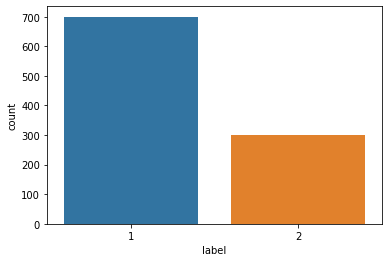

In [9]:
#Checking the distribution of each values in label 
sns.countplot('label', data=df)

Based on visualization below, we can see several things:
1. Good credit has a shorter credit duration, lower credit amount, and older age. (Although based on boxplot below we can see there are outliers in those data)
2. Bad credit on the other side, in general has a longer credit duration, higher credit amount, and younger age (also there are outliers).

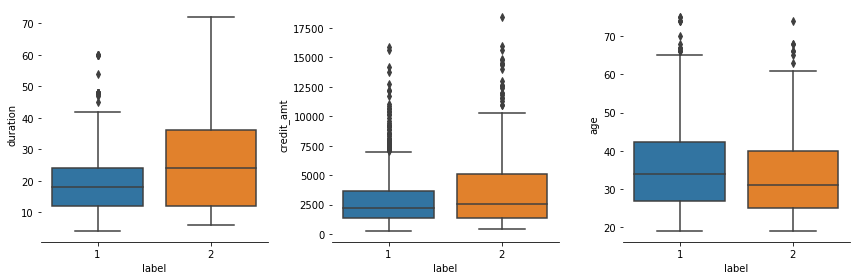

In [10]:
#Comparing duration, credit amount, and age variables with the label class
f, axes = plt.subplots(1, 3, figsize=(12,4), sharex=True)
sns.despine(left=True)

sns.boxplot('label','duration', data=df, ax=axes[0])
sns.boxplot('label','credit_amt',data=df, ax=axes[1])
sns.boxplot('label','age',data=df, ax=axes[2])

plt.tight_layout()

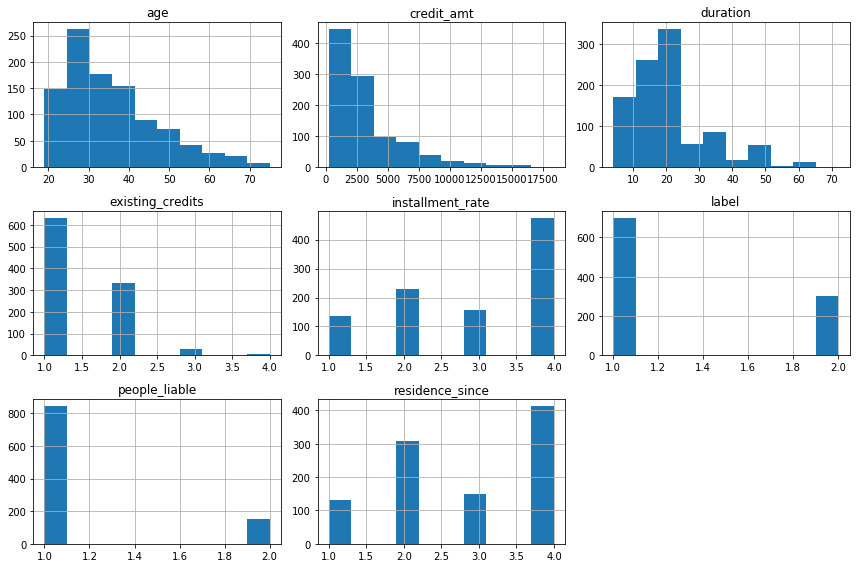

In [11]:
df.hist(figsize=(12,8))
plt.tight_layout()
plt.show()

Checking the correlation on each variables, we don't have many variables that is correlated except one, credit amount vs duration. This is quite true because in general, the higher your credit amount, you will have longer duration to pay.

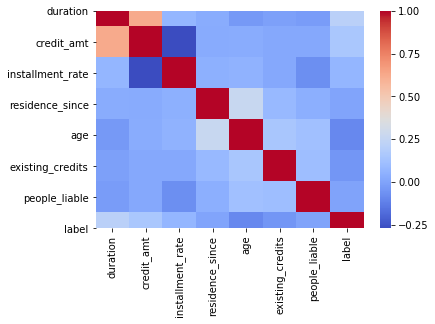

In [12]:
sns.heatmap(df.corr(),cmap='coolwarm')

Data Pre-processing

Now we are trying to converting the categorical data into numerical data, so we can work with a lot more features for prediction later. After converting, we have 61 features.

In [13]:
#Numerical Data
int_df = df.select_dtypes(include=['integer']).copy()
#Categorical Data
obj_df = df.select_dtypes(include=['object']).copy()

In [14]:
#One Hot Encoding, converting categorical data into numerical
cat_df = pd.get_dummies(obj_df)

Standardization

In [15]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

df_std = pd.DataFrame(std_scaler.fit_transform(int_df.drop(['label'], axis=1)))
df_std.columns = ['duration', 'credit_amt', 'installment_rate', 'residence_since', 'age', 'existing_credits', 'people_liable']

df_new = pd.concat([cat_df, df_std, df['label']], axis=1)

Comparing Machine Learning Algorithm

Now, it's time to work with ML algorithm, first we split the dataset into training and test set with around 33% test and 67% training.

In [16]:
from sklearn.model_selection import train_test_split
X = df_new.iloc[:,0:61]  #features columns
y = df_new.iloc[:,-1]    #label column

#Setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

We use K-Fold Cross Validation with the value of K=10.
We do this to evaluate our machine learning algorithm.
We used several machine learning algorithms, including ensemble method.
Since the data that we had is imblanced, we can't look only for accuracy. But we will have to see the precision and recall values.
Based on that, several algorithm have a pretty good score, the top 5 are RandomForest, GradientBoosting, ExtraTrees, LogisticRegression, and SVM.

In [17]:
#Original data
models = [LogisticRegression(max_iter=10000), SVC(), 
         GaussianNB(), KNeighborsClassifier(),
         DecisionTreeClassifier(), 
         RandomForestClassifier(n_estimators=100),
         ExtraTreesClassifier(n_estimators=100),
         AdaBoostClassifier(n_estimators=100), 
         GradientBoostingClassifier(n_estimators=100)]

models_columns = []
models_compare = pd.DataFrame(columns = models_columns)

#K-FOld CV = 10
row_index = 0
for alg in models:
    kfold = KFold(n_splits=10, random_state=101)
    models_name = alg.__class__.__name__
    models_compare.loc[row_index,'Models Name'] = models_name
    models_compare.loc[row_index, 'Models Accuracy'] = cross_val_score(alg, X_train, y_train, scoring='accuracy', cv=kfold).mean()*100.0
    models_compare.loc[row_index, 'Models Precision'] = cross_val_score(alg, X_train,y_train,scoring='precision',cv=kfold).mean()*100.0
    models_compare.loc[row_index, 'Models Recall'] = cross_val_score(alg, X_train, y_train, scoring='recall', cv=kfold).mean()*100.0

    row_index+=1
    
models_compare.sort_values(by = ['Models Accuracy'], ascending = False, inplace = True)    
models_compare

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is

,Models Name,Models Accuracy,Models Precision,Models Recall
8,GradientBoostingClassifier,76.268657,79.869325,87.914444
5,RandomForestClassifier,75.820896,77.684799,92.837382
6,ExtraTreesClassifier,74.925373,78.185364,89.780117
0,LogisticRegression,74.328358,78.366157,87.968608
1,SVC,74.328358,76.486160,92.184348
7,AdaBoostClassifier,73.731343,79.508039,84.862857
3,KNeighborsClassifier,73.283582,76.659401,89.693390
2,GaussianNB,66.865672,82.207191,67.785248
4,DecisionTreeClassifier,66.865672,78.720337,77.056859


Tuning Algorithm

Now, we will tune the best algorithm (except the ensemble method) which is Logistic Regression and SVM. We use GridSearchCV for  finding the best parameters for each algorithms.

In [25]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params, cv=10)
grid_log_reg.fit(X_train, y_train)

#logistic regression best parameters.
print("Best: %f using %s" % (grid_log_reg.best_score_, grid_log_reg.best_params_))


svc_params = {'C': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}


model = SVC()

grid_svc = GridSearchCV(SVC(), svc_params, cv=10)
grid_svc.fit(X_train, y_train)

#SVC best parameters.
print("Best: %f using %s" % (grid_svc.best_score_, grid_svc.best_params_))

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\LENOVO\Anaconda3\lib\site-packa

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic

Best: 0.750746 using {'C': 1, 'penalty': 'l2'}
Best: 0.762687 using {'C': 1.3, 'kernel': 'poly'}


Finalize Model

In [36]:
#Logistic Regression Model
log_reg_model = LogisticRegression(C=1, penalty='l2')
log_reg_model.fit(X_train, y_train)

#Preict the test dataset
log_reg_predictions = log_reg_model.predict(X_test)
print(accuracy_score(y_test, log_reg_predictions))
print(confusion_matrix(y_test, log_reg_predictions))
print(classification_report(y_test, log_reg_predictions))

0.7545454545454545
[[202  24]
 [ 57  47]]
              precision    recall  f1-score   support

           1       0.78      0.89      0.83       226
           2       0.66      0.45      0.54       104

    accuracy                           0.75       330
   macro avg       0.72      0.67      0.69       330
weighted avg       0.74      0.75      0.74       330



In [35]:
#SVC Model 
svc_model = SVC(C=1.3, kernel='poly')
svc_model.fit(X_train, y_train)

#Preict the test dataset
svc_predictions = svc_model.predict(X_test)
print(accuracy_score(y_test, svc_predictions))
print(confusion_matrix(y_test, svc_predictions))
print(classification_report(y_test, svc_predictions))

0.7454545454545455
[[209  17]
 [ 67  37]]
              precision    recall  f1-score   support

           1       0.76      0.92      0.83       226
           2       0.69      0.36      0.47       104

    accuracy                           0.75       330
   macro avg       0.72      0.64      0.65       330
weighted avg       0.73      0.75      0.72       330



We know that the data we used before was imbalanced, now I will try to balance the data using SMOTE technique

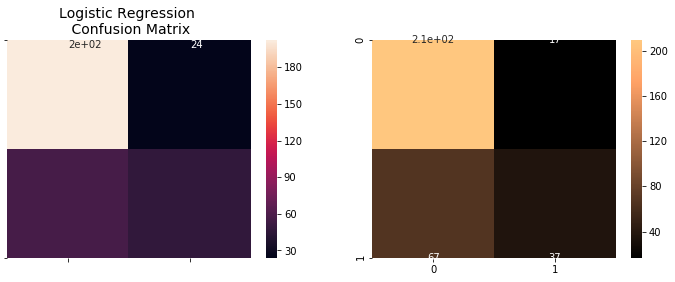

In [59]:
log_reg_cm = confusion_matrix(y_test, log_reg_predictions)
svc_cm = confusion_matrix(y_test, svc_predictions)


fig, ax = plt.subplots(1,2, figsize=(12,4))
annot_kws= {"ha": 'left',"va": 'top'}
sns.heatmap(log_reg_cm, ax=ax[0], annot=True, annot_kws=annot_kws)
ax[0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cm, ax=ax[1], annot=True, cmap=plt.cm.copper)

plt.show()

In [69]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix
[[202  24]
 [ 57  47]]
Confusion matrix
[[209  17]
 [ 67  37]]


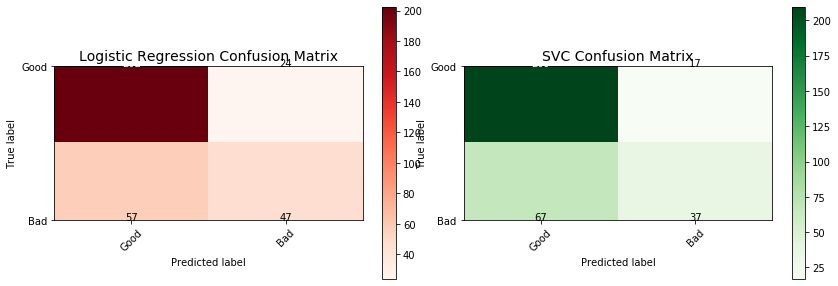

In [72]:
labels = ['Good', 'Bad']

fig = plt.figure(figsize=(12,8))

fig.add_subplot(221)
plot_confusion_matrix(log_reg_cm, labels, title="Logistic Regression Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(svc_cm, labels, title="SVC Confusion Matrix", cmap=plt.cm.Greens)